In [22]:

from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms

#dataset
from utils.dataset import CustomDataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler


from utils import models 
#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime


In [23]:
now = datetime.datetime.now()
weekday = now.strftime("%A")  # %A는 현재 요일을 나타내는 포맷 지정자입니다.
formatted_now = now.strftime("%Y%m%d%H%M")
checkpoint_datetime = formatted_now
print(f"#"*30, "SAVE TIME", "#"*30)
print(f"#"*30, checkpoint_datetime, "#"*30)

############################## SAVE TIME ##############################
############################## 202403141908 ##############################


In [24]:
train_csv = '../../dataset/train_meta.csv'

train_transform = transforms.Compose([
    # transforms.Resize((512,512), antialias= True),
    # transforms.RandomApply([
    #     transforms.RandomRotation(degrees = 30),
    #     transforms.RandomVerticalFlip(p= 0.5),
    #     transforms.RandomVerticalFlip(p=0.5),
    #     transforms.RandomCrop(size =224, scale= (0.8, 1.2), ratio = (0.75, 1.2), antialias = True),
    #     transforms.ColorJitter(brightness= 0.2, contrast = 0.2)
    # ]),
    transforms.ToTensor()
])

tr_batch = 80
vl_batch = 32

dataset = CustomDataset(
    csv_path= train_csv,
    transform= None, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = tr_batch
    # sampler= ImbalancedDatasetSampler(train_dataset),
)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)



torch.Size([80, 256, 256, 3])


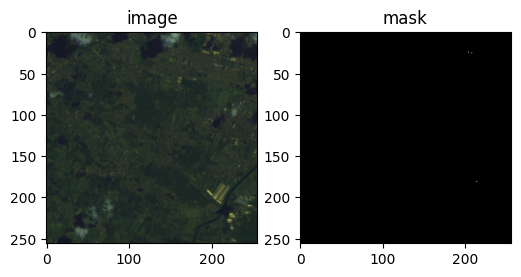

torch.Size([32, 256, 256, 3])


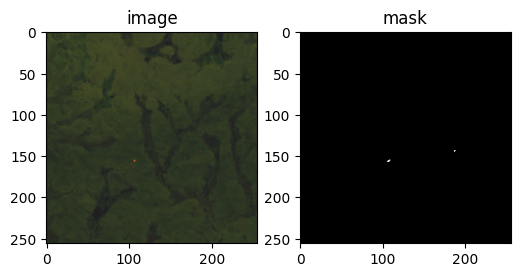

In [25]:
for images, masks in train_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

for images, masks in valid_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

In [28]:
metrics = {
    'tr_bce' : [],
    'vl_bce' : [],
    'tr_iou' : [],
    'vl_iou' : [],
}
epoch, epochs = 0, 200
early_stopping_epochs, early_stopping_cnt= 10, 0
SAVE_DIR = '../model'
best_loss = float('inf')

# random seed 고정
random.seed(42)
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed_all(42)
else:
    device = torch.device('cuda')
    torch.manual_seed_all(42)


# model & cost func & optimizer 정의
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

model.to(device)
lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95**epoch)

loss = nn.BCELoss()

print(f'device : {device}')
summary(model, input_size=(3, 224, 224))



device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,216
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,432
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,864
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14     

Using cache found in /home/eiden/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [32]:
def checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds):
    # loss plot
    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.plot(metrics['tr_bce'], label='Train Loss')
    plt.plot(metrics['vl_bce'], label='Valid Loss')
    plt.title("BCE LOSS")
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['tr_iou'], label='Train IoU')
    plt.plot(metrics['vl_iou'], label='Valid IoU')
    plt.title("mIOU LOSS")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_loss.png'))
    plt.close()
    
    # mask plot
    plt.figure(figsize=(10, 7))
    plt.subplot(131)
    plt.imshow(images[0].cpu().permute(1,2,0))
    plt.title('image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(masks[0].cpu().permute(1,2,0))
    plt.title('mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(preds[0].cpu().permute(1,2,0))
    plt.title('pred')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_mask.png'))
    plt.close()
    
    torch.save({
        "model" : f"{epoch}",
        "epoch" : epoch,
        "epochs" : epochs,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict" : optimizer.state_dict(),
        "learning_rate" : lr,
        "loss" : loss,
        "metric" : metrics,
        "description" : f"segmentation model training status : {epoch}/{epochs}"
    },
    os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}.pt'))
    
def calculate_iou(preds, masks, threshold=0.5):
    # 예측 마스크를 이진 형태로 변환
    preds = (preds > threshold).float()
    
    intersection = torch.sum(preds * masks)
    union = torch.sum((preds + masks) > 0)
    
    iou = (intersection + 1e-7) / (union + 1e-7)  # 0으로 나누는 경우를 방지하기 위해 작은 값(1e-7)을 추가
    
    return iou

In [31]:
for epoch in tqdm(range(epoch, epochs), desc="Training Progress"):
    train_losses, valid_losses = 0., 0.
    train_ious, valid_ious = 0., 0.
    
    model.train()
    for _, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, masks = images.to(device), masks.to(device)
        images = images.permute(0,3,1,2)
        masks = masks.permute(0,3,1,2)
        
        preds = model(images)
        train_loss = loss(preds, masks).to(device)
        train_iou = calculate_iou(preds, masks).cpu().numpy()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        train_ious += train_iou
    scheduler.step()

    print(f"Epoch : {epoch}/{epochs} | Train Loss : {train_losses / len(train_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Train IOU : {train_ious / len(train_loader)}")
    
    with torch.no_grad():
        model.eval()
        for _, (images, masks) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            images, masks = images.to(device), masks.to(device)
            images = images.permute(0,3,1,2)
            masks = masks.permute(0,3,1,2)

            preds = model(images)
            valid_loss = loss(preds, masks).to(device)
            valid_iou = calculate_iou(preds, masks).cpu().numpy()
        
    
            valid_losses += valid_loss.item()
            valid_ious += valid_iou
    print(f"Epoch : {epoch}/{epochs} | Valid Loss : {valid_losses / len(valid_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Valid IOU : {valid_ious / len(valid_loader)}")
            
    metrics['tr_bce'].append(train_losses / len(train_loader))
    metrics['vl_bce'].append(valid_losses / len(valid_loader))
    metrics['tr_iou'].append(train_ious / len(train_loader))
    metrics['vl_iou'].append(valid_ious / len(valid_loader))
    
    
    # Early Stopping
    if valid_losses < best_loss:
        best_loss = valid_losses
        early_stopping_cnt = 0
    else:
        early_stopping_cnt += 1
        if early_stopping_cnt >= early_stopping_epochs:
            print(f"Early Stops!!! : {epoch}/{epochs}")
            checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
            break
    
    # Validation 성능이 이전보다 우수한 경우 모델 저장
    try:        
        if valid_losses > np.array(metrics['vl_bce'])[:-1].max():
            checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    except Exception as e:
        print(e)
        pass

Training Progress:   0%|          | 0/182 [00:34<?, ?it/s]


KeyboardInterrupt: 